# Train car - v3

data ; crop and resize  
network ; xception , decrease batch_size. 

ImageAugment  ; shift add. 
random_eraser ; image part remove

first 200 epoch.
train acc;  , val acc;  , lb acc; 
model1 ; 66epoch, 93, 82
model2; 
model3 ;



## train ready

In [1]:
import sys
import pandas as pd

# from keras.applications import mobilenetv2
from keras.applications import xception
from keras.preprocessing import image
# import cv2
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Softmax
import random
from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.models import Input, Model
from sklearn.metrics import f1_score

from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

Using TensorFlow backend.


In [2]:
cache=False
basedir = './'

x_trainall = np.load('x_train.npy')
y_trainall = np.load('y_train.npy')
dfclass = pd.read_csv(basedir+'class.csv')

In [3]:
get_ipython().run_line_magic('matplotlib', 'inline')

In [4]:
imgwidth=224
imgheight=224

In [5]:
# cross validation
cvmode=3
datacnt = x_trainall.shape[0]
if cvmode==1:
    modelpath='car-v3-1.h5'
    # 7000, 2990
    print('cvmode=1')
    x_train = x_trainall[:7000]
    y_train = y_trainall[:7000]
    x_val = x_trainall[7000:]
    y_val = y_trainall[7000:]
elif cvmode==2:
    modelpath='car-v3-2.h5'
    print('cvmode=2')
    x_train = x_trainall[datacnt-7000:]
    y_train = y_trainall[datacnt-7000:]
    x_val = x_trainall[:datacnt-7000]
    y_val = y_trainall[:datacnt-7000]
elif cvmode==3:
    modelpath='car-v3-3.h5'
    print('cvmode=3')
    x_train = x_trainall[1000:8000]
    y_train = y_trainall[1000:8000]
    x_val = np.append( x_trainall[:1000], x_trainall[8000:] , axis=0 )
    y_val = np.append( y_trainall[:1000], y_trainall[8000:] )
    
del x_trainall
del y_trainall
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
print(np.min(y_train), np.max(y_train))

cvmode=3
(7000, 224, 224, 3) (7000,) (2990, 224, 224, 3) (2990,)
0 195


In [6]:
y_train_onehot = np_utils.to_categorical(y_train, 196)
y_val_onehot = np_utils.to_categorical(y_val, 196)

In [7]:
#ref: https://github.com/yu4u/cutout-random-erasing/blob/master/cifar10_resnet.py
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [8]:
# Image Augumentation
batch_size=16  # 32, 64
datagen1 = ImageDataGenerator(rescale=1./255, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, vertical_flip=False, 
                              width_shift_range=0.1, height_shift_range=0.1,
                              fill_mode='nearest', preprocessing_function = get_random_eraser(v_l=0, v_h=1),)
datagen2 = ImageDataGenerator(rescale=1./255)
train_generator = datagen1.flow(x_train, y_train_onehot, batch_size=batch_size)
val_generator = datagen2.flow(x_val, y_val_onehot, batch_size=batch_size, shuffle=False)

In [9]:
### checkpoint save weights in progress...
if not os.path.exists('ckpt'):
    os.mkdir('ckpt')
checkpoint_path='ckpt/check_{epoch:04d}.ckpt'
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, period=10)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0.001 )
# es_callback = keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=20, min_delta=0.01 )

# tensorboard log
if not os.path.exists('log'):
    os.mkdir('log')
tensorboard = TensorBoard(log_dir='log/'+str(time.time()))

In [10]:
force = False

if os.path.exists(modelpath) and force==False :
    cache=True
    print('cache model use... continuous!')
else:
    cache=False
    print('no cache model. create new model!')

no cache model. create new model!


In [11]:
# cache=True
# model
if cache==True:
    print('load model...')
#     model = load_model('car-v1-80.h5')
    model = load_model(modelpath)
else:
    inputs = Input(shape=(224,224,3))
#     net = mobilenetv2.MobileNetV2(input_tensor=inputs, input_shape=(224, 224, 3), alpha=1.0, include_top=False, weights='imagenet', pooling='max')
    net = xception.Xception(input_tensor=inputs, input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='max')
    net2 = Dense(224, activation='relu') (net.layers[-1].output)
    net2 = Dense(196)(net2)
    net2 = Softmax(196)(net2)

    model = Model(inputs=inputs, outputs=net2)
    print('new model...')

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
new model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
________________________

In [12]:
##### model freeze
if False:
    print('freezing...')
    for layer in model.layers[:-4]:
        layer.trainable=False
#     for layer in model.layers:
#         print(layer, layer.trainable)
#     model.summary()

In [13]:
if False:
    print('load weights...')
    model.load_weights('ckpt/check_0180.ckpt')

In [14]:
def new_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', new_score])

In [ ]:
# epochs = 100
hist = model.fit_generator( train_generator, initial_epoch=0, epochs = 500, validation_data=val_generator, 
                           callbacks=[tensorboard, cp_callback, es_callback],
                           steps_per_epoch=len(x_train)/batch_size, validation_steps=len(x_val)/batch_size)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/500
271/437 [=================>............] - ETA: 38s - loss: 5.2887 - acc: 0.0055

In [ ]:
# hist = model.evaluate( x_val/255., y_val_onehot, batch_size=30, verbose=1 )
# or 
hist = model.evaluate_generator(val_generator, steps=len(x_val)/batch_size)
print(hist)

In [ ]:
model.save(modelpath)

In [53]:
# test data load for submission
x_test = np.load('x_test.npy')
x_test = x_test/255.

In [26]:
# submission 
predictions = model.predict( x_test )
pdi = np.argmax(predictions, axis=1)
print(pdi, np.min(pdi), np.max(pdi))

[123  97 156 ...  43  49  93] 0 195


In [56]:
# ensamble. 
if False:
    mp1='car-v3-1.h5'
    mo1 = load_model(mp1)
    prediction1 = mo1.predict( x_test )

    mp2='car-v3-2.h5'
    mo2 = load_model(mp2)
    prediction2 = mo2.predict( x_test )

#     mp3='car-v3-3.h5'
#     mo3 = load_model(mp3)
#     prediction3 = mo3.predict( x_test )

    predictions = prediction1+prediction2  # +prediction3
    pdi3 = np.argmax(predictions, axis=1)

In [57]:
submission = pd.read_csv(basedir+'sample_submission.csv')
submission["class"] = pdi + 1  # class [0,195] to [1,196]  
submission.to_csv("submission.csv", index=False)
submission.head()


,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,98
2,test_00003.jpg,157
3,test_00004.jpg,94
4,test_00005.jpg,18


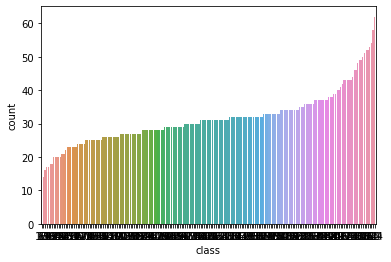

In [58]:
sns.countplot(submission["class"], order=submission["class"].value_counts(ascending=True).index)